# Final Exam (part 3) - Computational Physics 2

### Deadline: Friday 6 June 2025 (by 23h59)
### Credits: 10 points

### Name: Alan Palma

### Please keep the structure provided below and submit an organised notebook with clear answers to each item.


## 3. MPI Parallelisation of Molecular Dynamics Simulations

In this problem, you will use **Message Passing Interface (MPI)** library to parallelise the execution of molecular dynamics simulations for different temperatures. The goal is to distribute the simulation of various temperatures across multiple MPI processes, significantly reducing the overall computational time.

### Code:
The reference (serial) script can be found here:

https://github.com/wbandabarragan/computational-physics-2/blob/main/exams/thermostat.py

**You should only modify the code below the indicated line:**

`# Your MPI parallelization code should start here. Do not modify the code above.`

The core simulation logic within the `run` function should remain untouched.

This last problem directory has the following structure:

```
03part
├── 
│   ├── outputfolder_P3
│   └── *.png   
│   └── mpi_scaling.csv
└── final-exam-p3.ipynb
└── final_P3.out  
└── final_P3.err
└── job_final.sh
└── thermostat_mpi.py
```

- Here the ```job_final.sh``` is the bash script used for running the simulation along different number of cores. 
- ```final_P3.out``` and ```final_P3.err``` are the output files after running the simulation in the CEDIA cluster. 

**Note:** I removed the ```.dump``` files from the ```outputfolder_P3``` because they are too large.

### Tasks:

Use the provided script (`thermostat.py`) to create a new version of the script (`thermostat_mpi.py`) that uses the `mpi4py` library to parallelise the simulation execution. Here are the specific requirements for your MPI implementation:

**(a)** Set up a world communicator to distribute tasks among processes. Determine the rank of each process and the total number of processes.

First let's add this lines at the begining of the editable code in ```thermostat_mpi.py```:

```Python
# Get basic information about the MPI communicator
world_comm = MPI.COMM_WORLD
world_size = world_comm.Get_size()
my_rank = world_comm.Get_rank()

```

**(b)** Distribute a range of temperatures among the available MPI processes. Each process should be responsible for running the simulation at one or more unique temperatures.

For this purppse we first define a temperature array for running the simulations and then we distribute this array across the available cores.

```Python
# Define temperature range to simulate (K)
temp_min = 100
temp_max = 850
temp_step = 50
temps = np.arange(temp_min, temp_max + temp_step, temp_step)

# Default simulation parameters
params = {
'natoms': N_atoms,
'temp': 300,
'mass': 0.001,
'radius': 120e-12,
'relax': 1e-13,
'dt': 1e-15,
'steps': 10000,
'freq': 100,
'box': ((0, 1e-8), (0, 1e-8), (0, 1e-8)),
'ofname': 'traj-hydrogen-3D-{}.dump'.format(N_atoms)
}

# Simulation start time
start_time = time.time()

# Define number of temperatures
N_temps = len(temps)

# Distribute temperatures 
workloads = [N_temps // world_size for j in range(world_size)]
for i in range(N_temps % world_size):
    workloads[i] += 1

# Calculate the temperature range indices
my_start = 0
for i in range(my_rank):
    my_start += workloads[i]
my_end = my_start + workloads[my_rank]

# Get my assigned temperatures
my_temps = temps[my_start:my_end]
```

**(c)** Ensure proper initialization and finalization of the MPI environment. Cores should also send completion signals.

Check that temperatures was distributed correctly:

```Python
# Ensure good initialization
    print(f"Rank {my_rank} initialized with temperatures: {my_temps}")
```

The following code ensures the a proper completition signal in each rank using poin to point comunication:

```Python
if my_rank != 0:
    comm.send(True, dest=0, tag=42)
    print(f"Rank {my_rank} sent completion signal")
else:
    for i in range(1, world_size):
        comm.recv(source=i, tag=42)
        print(f"Rank 0 received completion signal of {my_rank}")
```


**(d)** The root/master process (rank 0) should handle workload communications and collect the simulation results from all other processes.

This piece of code collect all the results from all processes and combine in a single array for plotting:

```Python
# Gather all results from all processes
all_results = world_comm.gather(my_results, root=0)

#  Root process handles final output
if my_rank == 0:

    # Combine and sort results from all processes
    combined_results = []

    # combine results from all processes
    for results in all_results:

        # Agregate in combined_results
        combined_results.extend(results)
```

**(e)** For each simulated temperature, generate the `temperature-N_atoms.png` plot and the `traj-hydrogen-3D-N_atoms.dump` file. In addition the root/master process should:

- Collect and present the combined results (i.e., a single plot with all the temperature curves).

- Save the total execution time and the number of CPU cores used to a CSV file (`mpi_scaling.csv`). 

Finally, here is the **entire code**. Generating all temperature figures, all the temperature curves in single one and the .csv file required.

```Python

# -----------------------------------------------------------------------------
# Your MPI parallelization code should start here. Do not modify the code above.
# -----------------------------------------------------------------------------

# Run code wih desired parameters

N_atoms = 1000

if __name__ == '__main__':

    # Get basic information about the MPI communicator
    world_comm = MPI.COMM_WORLD
    world_size = world_comm.Get_size()
    my_rank = world_comm.Get_rank()

    # Define temperature range to simulate (K)
    temp_min = 100
    temp_max = 850
    temp_step = 50
    temps = np.arange(temp_min, temp_max + temp_step, temp_step)

    # Default simulation parameters
    params = {
    'natoms': N_atoms,
    'temp': 300,
    'mass': 0.001,
    'radius': 120e-12,
    'relax': 1e-13,
    'dt': 1e-15,
    'steps': 10000,
    'freq': 100,
    'box': ((0, 1e-8), (0, 1e-8), (0, 1e-8)),
    'ofname': 'traj-hydrogen-3D-{}.dump'.format(N_atoms)
    }

    # Simulation start time
    start_time = time.time()

    # Define number of temperatures
    N_temps = len(temps)

    # Distribute temperatures 
    workloads = [N_temps // world_size for j in range(world_size)]
    for i in range(N_temps % world_size):
        workloads[i] += 1
    
    # Calculate the temperature range indices
    my_start = 0
    for i in range(my_rank):
        my_start += workloads[i]
    my_end = my_start + workloads[my_rank]
    
    # Get my assigned temperatures
    my_temps = temps[my_start:my_end]

    # Ensure good initialization
    print(f"Rank {my_rank} initialized with temperatures: {my_temps}")

    my_results = []
    for i, temp in enumerate(my_temps):

        # Copy the parameters and set the temperature
        my_params = params.copy()
        my_params['temp'] = my_temps[i]
        my_params['ofname'] = f'traj-hydrogen-3D-{N_atoms}-T{int(temp)}.dump'

        # Run the simulation and save dump file
        output = run(**my_params)

        # Store the results for each rank
        my_results.append([temp, output])

        # Save the individual temperature output
        plt.figure(figsize=(10,6))

        plt.plot(output[:,0] * 1e12, output[:,1])

        plt.xlabel("Time (ps)")
        plt.ylabel("Temperature (K)")
        plt.title(f"Temperature Evolution for {N_atoms} Atoms at {temp}K \n ({world_size} MPI Processes)")
        plt.ylim(0., np.max(temps) + 75.)

        plt.grid(True, alpha = 0.2)

        plt.savefig(f"./temperature{temp}"+"-{}.png".format(N_atoms))
        plt.close()
    
    # Completition signal to root process
    if my_rank != 0:
        world_comm.send(True, dest=0, tag=42)
        print(f"Rank {my_rank} sent completion signal")
    else:
        for i in range(1, world_size):
            world_comm.recv(source=i, tag=42)
            print(f"Rank 0 received completion signal of {my_rank}")

    # Gather all results from all processes
    all_results = world_comm.gather(my_results, root=0)

    #  Root process handles final output
    if my_rank == 0:

        # Combine and sort results from all processes
        combined_results = []

        # combine results from all processes
        for results in all_results:

            # Agregate in combined_results
            combined_results.extend(results)
    
        # Create combined plot
        plt.figure(figsize=(10,6))
        for temp, output in combined_results:

            plt.plot(output[:,0] * 1e12, output[:,1], label=f'{temp}K')
        
        plt.xlabel("Time (ps)")
        plt.ylabel("Temperature (K)")
        plt.title(f"Temperature Evolution for {N_atoms} Atoms \n ({world_size} MPI Processes)")

        plt.legend()
        plt.grid(True, alpha=0.2)

        plt.savefig(f"./temperature-combined-{N_atoms}.png")
        plt.close()
        
        # Save performance data
        time_tot = time.time() - start_time

        with open('mpi_scaling.csv', 'a') as f:
            f.write(f"{world_size},{time_tot}\n")
        
        print(f"Simulated {N_temps} temperatures using {world_size} processes")
        print(f"Total execution time: {time_tot:.2f} seconds")
    
    # Finalize the MPI environment
    MPI.Finalize()
```

**(f)** Run the script with `mpirun` and different number of processors in an HPC facility.

The bash script ```job_final.sh``` was used for running the simulation for various number of CPU cores:

```bash
#!/bin/bash
#SBATCH --job-name=final_P3
#SBATCH --partition=cpu
#SBATCH --time=00:20:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=1G
#SBATCH --output=final_P3.out
#SBATCH --error=final_P3.err
    
. ~/.bashrc
conda activate py310

# create output directory
mkdir -p outputfolder_P3
cd outputfolder_P3/

# Loop over different numbers of processors
for n_cpu 
in 1 2 4 8 16 32; do

    echo "Running with $n_cpu CPU(s)..."

    mpirun --oversubscribe -np $n_cpu python ../thermostat_mpi.py $n_cpu
	
    wait

done
```

### Scaling and analysis:

Report the simulation results (temperature plots and scaling) in this notebook:

**(g)** After running the MPI code for various numbers of CPU cores (e.g., 1, 2, 4, 8, 16, etc.), use the data accumulated in the CSV file (`mpi_scaling.csv`) from multiple runs to:

- Plot the observed speedup (e.g., $S_p = T_1 / T_p$, where $T_1$ is the execution time on 1 CPU and $T_p$ is the execution time on $p$ CPUs) as a function of the number of CPU cores.

In [23]:
# Third party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

# Define the style for plotting
plt.style.use(['science', 'notebook', 'no-latex']) 

In [24]:
# Read the data from cvs
path = "outputfolder_P3/"
file_name = "mpi_scaling.csv"
data = pd.read_csv(path + file_name, header = None, sep = ",")

In [25]:
# Convert to numpy arrays
np_cpus = np.array(data[0], dtype=int)
np_time = np.array(data[1], dtype=float)

# Compute speedup
np_speedup = np_time[0] / np_time

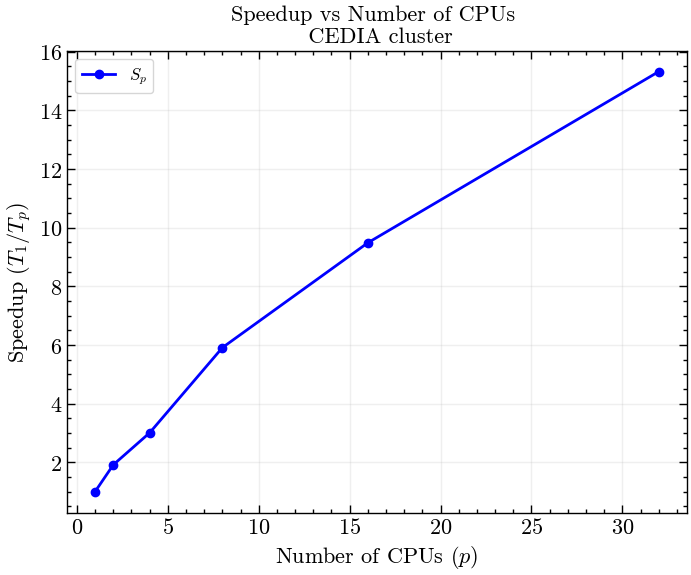

In [26]:
# Plot the data

plt.figure(figsize=(8, 6))
plt.plot(np_cpus, np_speedup, marker="o", linestyle="-", color="blue", label=r"$S_{p}$")

plt.xlabel(r"Number of CPUs ($p$)")
plt.ylabel(r"Speedup ($T_1/T_p$)")
plt.title("Speedup vs Number of CPUs \n CEDIA cluster")

plt.grid(True, alpha=0.2)
plt.legend(frameon=True, fontsize=12)

plt.show()

- Compare your observed speedup to Amdahl's Law and discuss any discrepancies between the observed and theoretical speedup.

Amdahl's law:

$$
\frac{1}{(1-P)+P/N}
$$

Where $N$ is the number of processes and $P$ is the portion of the code that can be parallelized

In [27]:
# Portion of the code that can be parallelized
p_arr = np.linspace(0.92, 1., 4)

# Store the speedup values 
speedup_values = []

for P in p_arr:

    # Compute the speedup for each portion of the code
    speedup = lambda N: 1 / ((1 - P)+ P/N)

    # Append the speedup values evaluated
    speedup_values.append(speedup(np_cpus))

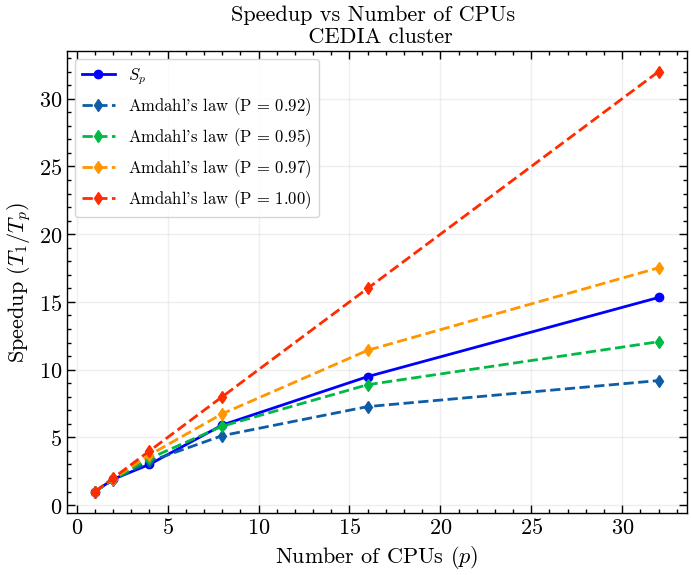

In [28]:
# Plot the data

plt.figure(figsize=(8, 6))
plt.plot(np_cpus, np_speedup, marker="o", linestyle="-", color="blue", label=r"$S_{p}$")

for i, P in enumerate(p_arr):
    speedup = speedup_values[i]
    plt.plot(np_cpus, speedup, marker="d", linestyle="--", label=r"Amdahl's law (P = ${:.2f}$)".format(P))

plt.xlabel(r"Number of CPUs ($p$)")
plt.ylabel(r"Speedup ($T_1/T_p$)")
plt.title("Speedup vs Number of CPUs \n CEDIA cluster")

plt.grid(True, alpha=0.2)
plt.legend(frameon=True, fontsize=12)

plt.show()

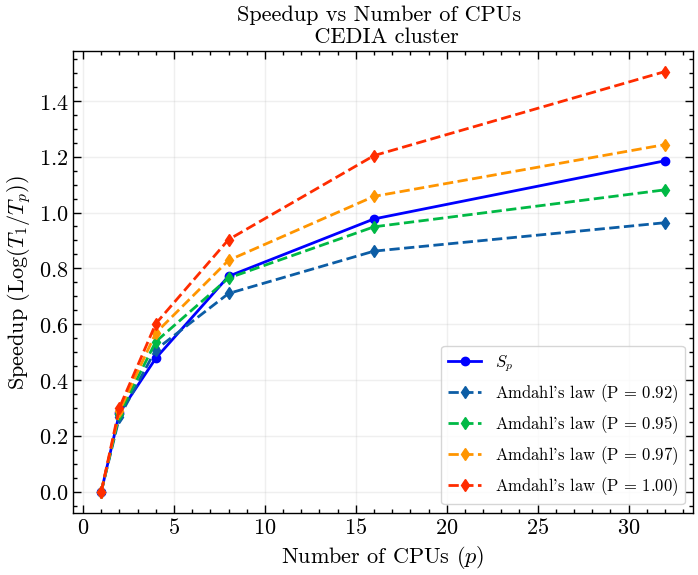

In [31]:
# Plot the data

plt.figure(figsize=(8, 6))
plt.plot(np_cpus, np.log10(np_speedup), marker="o", linestyle="-", color="blue", label=r"$S_{p}$")

for i, P in enumerate(p_arr):
    speedup = speedup_values[i]
    plt.plot(np_cpus, np.log10(speedup), marker="d", linestyle="--", label=r"Amdahl's law (P = ${:.2f}$)".format(P))

plt.xlabel(r"Number of CPUs ($p$)")
plt.ylabel(r"Speedup (Log($T_1/T_p$))")
plt.title("Speedup vs Number of CPUs \n CEDIA cluster")

plt.grid(True, alpha=0.2)
plt.legend(frameon=True, fontsize=12)

plt.show()

As is well known, not all tasks in a code can be fully parallelized. This prevents the runtime from perfectly following Amdahl's Law, especially due to the communication overhead between processes. The figure shows how well the code is parallelized, and we observe an improvement in speedup as the number of cores increases. However, in our example, the results do not fit Amdahl's Law perfectly due to the time required for inter-process communication and for gathering all the results and making the combined figure (executed in rank 0).